In [86]:
import pandas as pd
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

Initial Steps
---

1. Read the data
2. Plot the histogram

(0, 200)

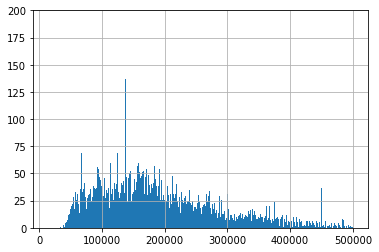

In [87]:
housing = pd.read_csv("housing.csv")
housing["median_house_value"].hist(bins=1000)
plt.ylim([0, 200])

Outlier Detection
---

There are some obvious outliers in the data (which we saw previously and above). Let's see if we can detect them using the modified z-score method. First, we need to group the data by the `median_house_value` and get the counts from any column.

In [88]:
counts = housing.groupby(['median_house_value']).count()['longitude']

Modified Z-Score
---

$$M_i = \frac{0.6745(x_i - \tilde{x})}{\text{MAD}}$$

where $\tilde{x}$ is the median and $\text{MAD}$ is the median absolute deviation.

$$\text{MAD} = \text{median}(|x_i - \tilde{x}|)$$

$M_i$ which are greater than 3.5 are considered potential outliers.

In [89]:
def outliers_modified_zscore(ys):
    median = np.median(ys)
    median_absolute_dev = np.median(np.abs(ys - median))
    modified_z_scores = 0.6745 * (ys - median) / median_absolute_dev
    return modified_z_scores

Generate the Outliers
---

1. Get the zscores and the outliers

In [90]:
zscores = outliers_modified_zscore(counts.values)
outliers = counts[zscores > 3.5]

Plot the Outliers
---

Found the tick labels trick on Stack Overflow [here](https://stackoverflow.com/a/19387765/2216847)

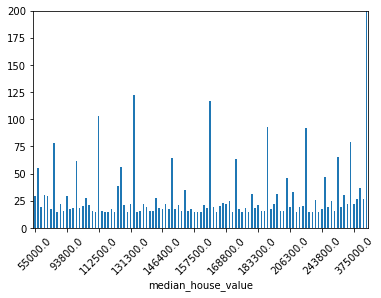

In [91]:
ax = outliers.plot(kind="bar", ylim=[0, 200], rot=45)
n = 10
ticks = ax.xaxis.get_ticklocs()
ticklabels = [l.get_text() for l in ax.xaxis.get_ticklabels()]
ax.xaxis.set_ticks(ticks[::n])
ax.xaxis.set_ticklabels(ticklabels[::n])

What points to remove?
---

A decent cutoff looks like a count of $\sim 25$

In [92]:
actual_outliers = outliers[outliers >= 25]

How much data do we lose?
---

In [93]:
print(counts.sum())
print(outliers[outliers >= 25].sum())

20640
2646


Remove the Data
---

In [94]:
for outlier in actual_outliers.keys():
    housing = housing[housing.median_house_value != outlier]

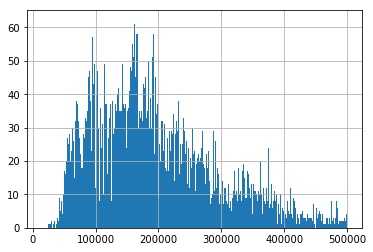

In [95]:
housing["median_house_value"].hist(bins=1000)

Write to File
---

In [96]:
housing.to_csv("housing-cleaned.csv", index=False)

Missing Data
---

The `total_bedrooms` is sometimes missing. Use SciKit-Learn's `Imputer` to set all missing values to the median. It only works on numeric data, need to drop the `ocean_proximity` bit

#### Numerical Data

In [97]:
from sklearn.preprocessing import Imputer
imputer = Imputer(strategy="median")

housing_numeric_only = housing.drop("ocean_proximity", axis=1)

imputer.fit(housing_numeric_only)

Imputer(axis=0, copy=True, missing_values='NaN', strategy='median', verbose=0)

In [98]:
# The "trained" medians
imputer.statistics_

array([ -1.18510000e+02,   3.42700000e+01,   2.80000000e+01,
         2.18350000e+03,   4.44000000e+02,   1.20700000e+03,
         4.19000000e+02,   3.53750000e+00,   1.74850000e+05])

In [99]:
X = imputer.transform(housing_numeric_only)
housing_tr = pd.DataFrame(X, columns=housing_numeric_only.columns)

Transformation Pipelines
---

In [100]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, LabelBinarizer

numeric_pipeline = Pipeline([
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('binarizer', LabelBinarizer())
])

housing_numeric_tr = numeric_pipeline.fit_transform(housing_numeric_only)
housing_categorical_tr = categorical_pipeline.fit_transform(housing["ocean_proximity"])

Combining Everything into One Pipeline
---

In [101]:
from sklearn.base import BaseEstimator, TransformerMixin

class DataFrameSelector(BaseEstimator, TransformerMixin):
    def __init__(self, attribute_names):
        self.attribute_names = attribute_names
    def fit(self, X, y=None):
        return self
    def transform(self, X):
        return X[self.attribute_names].values

In [102]:
from sklearn.pipeline import FeatureUnion

numeric_attributes = list(housing.drop("ocean_proximity", axis=1))
categorical_attributes = ["ocean_proximity"]

numeric_pipeline = Pipeline([
    ('selector', DataFrameSelector(numeric_attributes)),
    ('imputer', Imputer(strategy="median")),
    ('std_scaler', StandardScaler())
])

categorical_pipeline = Pipeline([
    ('selector', DataFrameSelector(categorical_attributes)),
    ('binarizer', LabelBinarizer())
])

full_pipeline = FeatureUnion(transformer_list=[
    ("numeric_pipeline", numeric_pipeline),
    ("categorical_pipeline", categorical_pipeline)
])

housing_prepared = full_pipeline.fit_transform(housing)